In [17]:
import os
import pathlib

import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf

from tensorflow.keras import layers
from tensorflow.keras import models

seed = 42
tf.random.set_seed(seed)
np.random.seed(seed)

In [18]:
DATASET_PATH = 'barkmeow'

data_dir = pathlib.Path(DATASET_PATH)
commands = np.array(tf.io.gfile.listdir(str(data_dir)))

In [19]:
filenames = tf.io.gfile.glob(str(data_dir) + '/*/*')
filenames = tf.random.shuffle(filenames)
num_samples = len(filenames)
train_files = filenames[:round(num_samples*0.8)]
val_files = filenames[round(num_samples*0.8):round(num_samples*0.8)+round(num_samples*0.1)]
test_files = filenames[-round(num_samples*0.1):]

In [20]:
def decode_audio(audio_binary):
  audio, _ = tf.audio.decode_wav(contents=audio_binary)
  return tf.squeeze(audio, axis=-1)
def get_label(file_path):
  parts = tf.strings.split(
      input=file_path,
      sep=os.path.sep)
  return parts[-2]
def get_waveform_and_label(file_path):
  label = get_label(file_path)
  audio_binary = tf.io.read_file(file_path)
  waveform = decode_audio(audio_binary)
  return waveform, label


In [21]:
AUTOTUNE = tf.data.AUTOTUNE

files_ds = tf.data.Dataset.from_tensor_slices(train_files)

waveform_ds = files_ds.map(
    map_func=get_waveform_and_label,
    num_parallel_calls=AUTOTUNE)

In [22]:
def get_spectrogram(waveform):
  input_len = 16000
  waveform = waveform[:input_len]
  zero_padding = tf.zeros(
      [16000] - tf.shape(waveform),
      dtype=tf.float32)
  waveform = tf.cast(waveform, dtype=tf.float32)
  equal_length = tf.concat([waveform, zero_padding], 0)
  spectrogram = tf.signal.stft(
      equal_length, frame_length=255, frame_step=128)
  spectrogram = tf.abs(spectrogram)
  spectrogram = spectrogram[..., tf.newaxis]
  return spectrogram

In [23]:
def plot_spectrogram(spectrogram, ax):
  if len(spectrogram.shape) > 2:
    assert len(spectrogram.shape) == 3
    spectrogram = np.squeeze(spectrogram, axis=-1)
  log_spec = np.log(spectrogram.T + np.finfo(float).eps)
  height = log_spec.shape[0]
  width = log_spec.shape[1]
  X = np.linspace(0, np.size(spectrogram), num=width, dtype=int)
  Y = range(height)
  ax.pcolormesh(X, Y, log_spec)

In [24]:
def get_spectrogram_and_label_id(audio, label):
  spectrogram = get_spectrogram(audio)
  label_id = tf.argmax(label == commands)
  return spectrogram, label_id

In [25]:
spectrogram_ds = waveform_ds.map(
  map_func=get_spectrogram_and_label_id,
  num_parallel_calls=AUTOTUNE)

In [26]:
def preprocess_dataset(files):
  files_ds = tf.data.Dataset.from_tensor_slices(files)
  output_ds = files_ds.map(
      map_func=get_waveform_and_label,
      num_parallel_calls=AUTOTUNE)
  output_ds = output_ds.map(
      map_func=get_spectrogram_and_label_id,
      num_parallel_calls=AUTOTUNE)
  return output_ds

In [27]:
train_ds = spectrogram_ds
val_ds = preprocess_dataset(val_files)
test_ds = preprocess_dataset(test_files)


In [28]:
batch_size = 64
train_ds = train_ds.batch(batch_size)
val_ds = val_ds.batch(batch_size)


In [29]:
train_ds = train_ds.cache().prefetch(AUTOTUNE)
val_ds = val_ds.cache().prefetch(AUTOTUNE)


In [30]:
for spectrogram, _ in spectrogram_ds.take(1):
  input_shape = spectrogram.shape
num_labels = len(commands)

norm_layer = layers.Normalization()
norm_layer.adapt(data=spectrogram_ds.map(map_func=lambda spec, label: spec))

model = models.Sequential([
    layers.Input(shape=input_shape),
    layers.Resizing(32, 32),
    norm_layer,
    layers.Conv2D(32, 3, activation='relu'),
    layers.Conv2D(64, 3, activation='relu'),
    layers.MaxPooling2D(),
    layers.Dropout(0.25),
    layers.Flatten(),
    layers.Dense(128, activation='relu'),
    layers.Dropout(0.5),
    layers.Dense(num_labels),
])


In [31]:
model.compile(
    optimizer=tf.keras.optimizers.Adam(),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy'],
)

In [32]:
EPOCHS = 40
history = model.fit(
    train_ds,
    validation_data=val_ds,
    epochs=EPOCHS,
    callbacks=None,
)

Epoch 1/40
2/2 [==============================] - 2s 620ms/step - loss: 1.2072 - accuracy: 0.3223 - val_loss: 0.9219 - val_accuracy: 0.5333
Epoch 2/40
2/2 [==============================] - 0s 146ms/step - loss: 0.7658 - accuracy: 0.7521 - val_loss: 1.1508 - val_accuracy: 0.4667
Epoch 3/40
2/2 [==============================] - 0s 72ms/step - loss: 0.6318 - accuracy: 0.7686 - val_loss: 1.2619 - val_accuracy: 0.4667
Epoch 4/40
2/2 [==============================] - 0s 70ms/step - loss: 0.5515 - accuracy: 0.7851 - val_loss: 1.2734 - val_accuracy: 0.5333
Epoch 5/40
2/2 [==============================] - 0s 69ms/step - loss: 0.4801 - accuracy: 0.8347 - val_loss: 1.3953 - val_accuracy: 0.5333
Epoch 6/40
2/2 [==============================] - 0s 69ms/step - loss: 0.4342 - accuracy: 0.8430 - val_loss: 1.6671 - val_accuracy: 0.5333
Epoch 7/40
2/2 [==============================] - 0s 52ms/step - loss: 0.3804 - accuracy: 0.8678 - val_loss: 2.0091 - val_accuracy: 0.5333
Epoch 8/40
2/2 [=========

In [36]:
test_audio = []
test_labels = []

for audio, label in test_ds:
  test_audio.append(audio.numpy())
  test_labels.append(label.numpy())

test_audio = np.array(test_audio)
test_labels = np.array(test_labels)

In [37]:
y_pred = np.argmax(model.predict(test_audio), axis=1)
y_true = test_labels

test_acc = sum(y_pred == y_true) / len(y_true)
print(f'Test set accuracy: {test_acc:.0%}')

Test set accuracy: 93%


In [38]:
model.save("./model")

INFO:tensorflow:Assets written to: ./model\assets


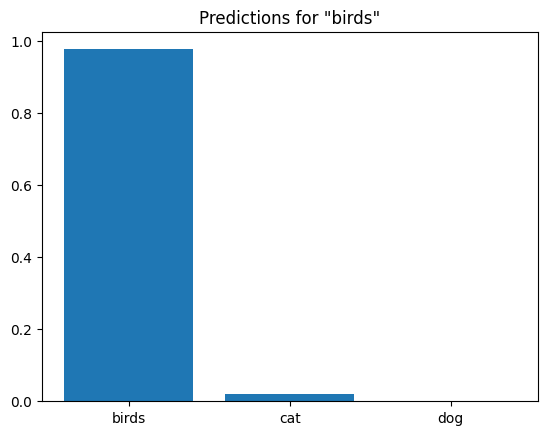

In [41]:
sample_file = data_dir/'../test/oiseau1.wav'

sample_ds = preprocess_dataset([str(sample_file)])

for spectrogram, label in sample_ds.batch(1):
  prediction = model(spectrogram)
  plt.bar(commands, tf.nn.softmax(prediction[0]))
  plt.title(f'Predictions for "{commands[label[0]]}"')
  plt.show()
